# Resnet feature extractor and UMAP plotting

In [1]:
# import sys
# sys.path.append('../../')
import numpy as np
import random as rand
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.applications import ResNet50
#from cellx.tools.projection import ManifoldProjection2D as MyManifoldProjection2D
import tifffile as tiff
import glob
import os
from tqdm.notebook import tnrange, tqdm, tqdm_notebook
from skimage.transform import resize
from datetime import datetime
import time
import itertools
import sys
sys.path.append('../../')
import cellx.cellx.manifold.projection as projection

2021-08-10 16:42:28.626388: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Define function to normalise images for resnet inference

In [2]:
def normalize_image_array(img):
    img_mean = np.mean(img)
    img_stddev = max(np.std(img), 1.0/np.size(img))
    img = np.subtract(img, img_mean)
    img = np.divide(img, img_stddev)
    # clip to 4 standard deviations
    img = np.clip(img, -4, 4)
    return img

In [3]:
def norm(x):
    return (x-np.mean(x)) / np.max([np.std(x), 1/np.prod(x.shape)])

## Define Resnet
Shape of Resnet input and load model

In [4]:
# resnet input: needs 3 channels
INPUT_SHAPE = (32, 32, 3)
# get pre-trained resnet
model = ResNet50(
    include_top=False, # exclude final fully-connected layer
    weights="imagenet",
    input_shape=INPUT_SHAPE,)
model.summary()

2021-08-10 16:42:42.152272: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-10 16:42:46.483076: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-10 16:42:46.483267: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mr-susan): /proc/driver/nvidia/version does not exist
2021-08-10 16:42:46.485932: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Set path to images
Find images and define N, the number of individual images you wish to load

In [5]:
files = glob.glob('/home/nathan/data/confocal/pcna/glimpses/non_edge_32px/*.tif')#'/home/nathan/data/kraken/pcna/local_glimpses/all/*.tif')
stack, flat_stack = [], []
N = int(len(files))
print('Number of images:', N)

Number of images: 32002


## Load images
Dependent on computer but flash storage on my laptop can load a (175,000, 32, 32) stack in approx. 3.5 minutes

In [6]:
for i, file in tqdm_notebook(enumerate(files), total = N):
    if i < N:
        tif = np.array(tiff.imread(file),dtype=np.uint8)
        tif = resize(tif, (32,32))
        stack.append(tif)
imgs = np.stack(stack, axis = 0)
#flat_imgs = np.stack(flat_stack, axis = 0)
imgs.shape#, flat_imgs.shape
## getting rid of stack to save memory?
stack = []

  0%|          | 0/32002 [00:00<?, ?it/s]

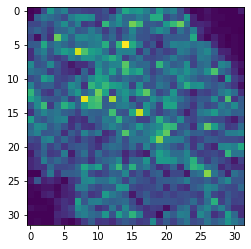

In [7]:
plt.imshow(imgs[0])

#### Display a small subsection of images
To check that data has loaded

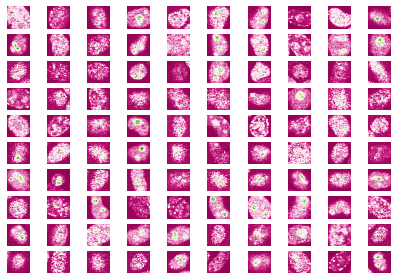

In [8]:
fig, ax_array = plt.subplots(10, 10)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(imgs[i], cmap='PiYG')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

## Transform images
From single-channel to 3-channel for Resnet and UMAP

In [9]:
imgs = np.repeat(imgs[..., np.newaxis], 3, axis=-1)
imgs.shape

(32002, 32, 32, 3)

## Generate labels
Obtain precise and coarse data labels from the filename of each image which is labelled with fractional age of cell 

In [10]:
labels, coarse_labels = [], []
for j, i in enumerate(files):
  if j < N:
    label = float((i.split('age')[1]).split('.tif')[0]) 
    labels.append(label)
    if label < 0.34:
      coarse_label = 0
    elif label <0.67:
      coarse_label = 0.5
    else:
      coarse_label = 1
    coarse_labels.append(coarse_label)
#print(labels)

## Normalisation: is this necessary? Memory bottleneck causes laptop to crash
Normalise images and covert to float32 for Resnet

In [11]:
imgs[0].dtype

dtype('float64')

old method

In [12]:
# imgs = normalize_image_array(imgs.astype(np.float32))
# imgs.shape, imgs.dtype

new method, need to ensure is float32

In [13]:
imgs = norm(imgs)
imgs.shape, imgs.dtype

((32002, 32, 32, 3), dtype('float64'))

## Extract features with trained resnet

In [14]:
test_features = model.predict(imgs, batch_size=64)
test_features.shape

2021-08-10 16:43:53.835640: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-10 16:43:53.878709: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3499910000 Hz


(32002, 1, 1, 2048)

In [25]:
test_features[0,:,:]

array([[[0.       , 0.       , 0.       , ..., 4.5934286, 0.       ,
         0.       ]]], dtype=float32)

## Preprocessing for dimensionality reduction

In [15]:
# reshape model predictions to 2D array
X = test_features.reshape(test_features.shape[0], -1)
print(X.shape)
# standard scaling -- Standardize features by removing the mean and scaling to unit variance
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)

(32002, 2048)


# Define hyperparameters for UMAP
`nbs` = nearest neighbours

`eps` = epochs

In [27]:
nbs = 5
eps = 2000
rnd = 0

## Run UMAP 

In [28]:
### UMAP() calls the UMAP object and defines the various hyperparams
mapper = UMAP(n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
### fit() method finds a low dimensional representation of hte data
mapper.fit(X)

UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=2000, n_neighbors=5,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 18:05:08 2021 Finding Nearest Neighbors
Tue Aug 10 18:05:08 2021 Building RP forest with 14 trees
Tue Aug 10 18:05:10 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Tue Aug 10 18:05:11 2021 Finished Nearest Neighbor Search
Tue Aug 10 18:05:11 2021 Construct embedding
	completed  0  /  2000 epochs
	completed  200  /  2000 epochs
	completed  400  /  2000 epochs
	completed  600  /  2000 epochs
	completed  800  /  2000 epochs
	completed  1000  /  2000 epochs
	completed  1200  /  2000 epochs
	completed  1400  /  2000 epochs
	completed  1600  /  2000 epochs
	completed  1800  /  2000 epochs
Tue Aug 10 18:06:38 2021 Finished embedding


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=2000, n_neighbors=5,
     random_state=0, verbose=True)

## Plot mapper embedding

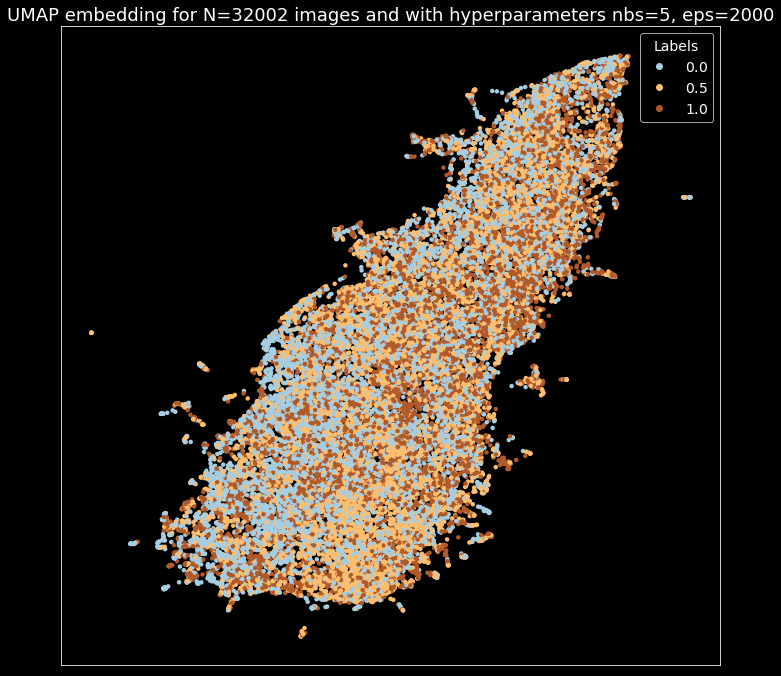

In [29]:
fig, ax = plt.subplots(figsize=(9.5, 9.5))
scatter = ax.scatter(mapper.embedding_[:, 1], 
                     mapper.embedding_[:, 0], 
                     c=coarse_labels, 
                     cmap="Paired", 
                     alpha=1, 
                     edgecolors="none", s=20, zorder=1)

ax.set_title("UMAP embedding for N={} images and with hyperparameters nbs={}, eps={}".format(N,nbs,eps), fontsize=18)
ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
ax.set_facecolor('k')
ax.set_axisbelow(True)
ax.grid(color="0.25", linestyle="--")

plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# fig.savefig(f"/content/drive/MyDrive/PhD/export_data/umap_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

## Plot manifold projection of images onto UMAP

In [30]:
bins = 50
embed_imgs = ((imgs-np.min(imgs))/(np.ptp(imgs)) * 255).astype(np.uint32)##np.uint8)
#mapper_projection = MyManifoldProjection2D(embed_imgs, output_shape=(32,32))
mapper_projection = projection.ManifoldProjection2D(embed_imgs, output_shape=(32,32))
img_grid, heatmap, delimiters = mapper_projection(mapper.embedding_, components=(0,1), bins=bins, method='rand')## method='sum'

100%|██████████████████████████████████████| 1013/1013 [00:01<00:00, 506.63it/s]


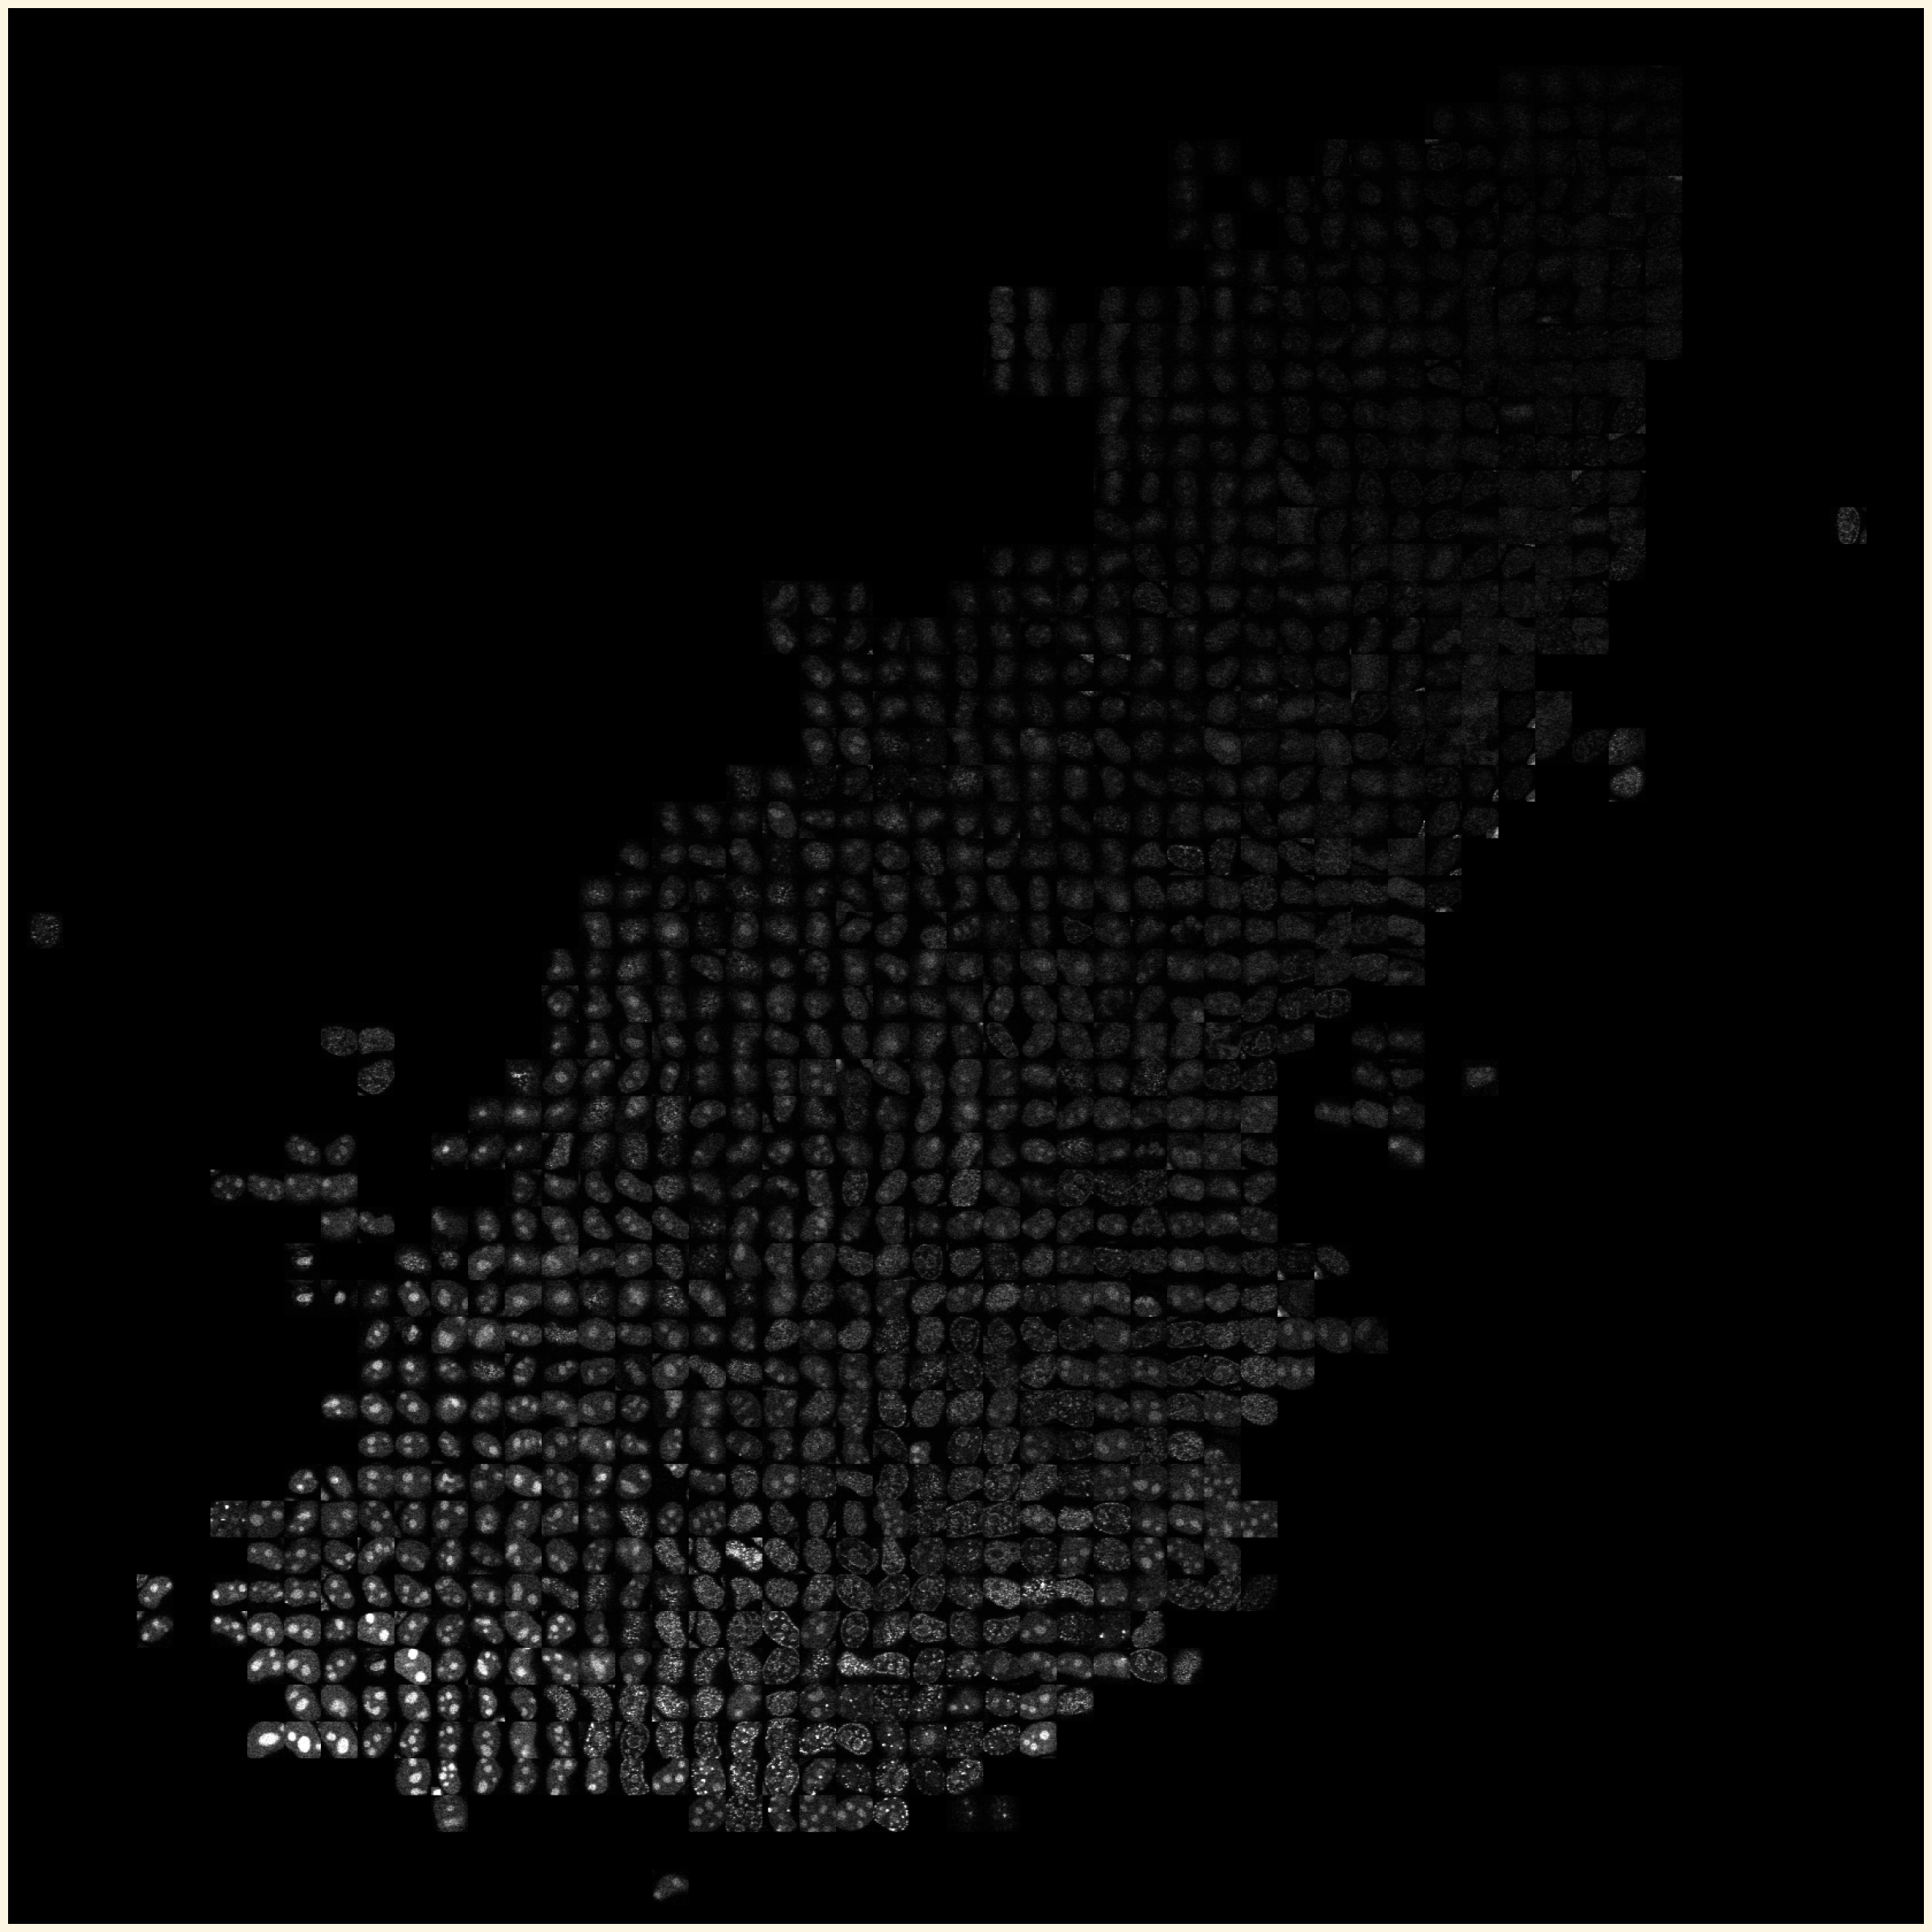

In [40]:
fig, ax = plt.subplots(figsize=(24,24))
im = plt.imshow(img_grid,
                origin="lower",
                #extent=delimiters, 
                #vmin=0, vmax=255, # modify or comment out according to image intensity values to show
                cmap="gray",)
plt.axis('off')
plt.tight_layout()
#plt.colorbar()
fn = '/home/nathan/data/analysis_results/UMAP/confocal/trial_output/manifold_projection_nbs{}_eps{}_{}.png'.format(nbs, eps, time.strftime("%Y%m%d-%H%M%S"))
plt.savefig(fn, dpi=300, bbox_inches="tight")

# Iterating over all of the above with different hyperparameters
The following functions take the previously loaded imagery and put it through the UMAP pipeline to test on different settings

In [48]:
def create_UMAP_projection(nbs, eps, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print('output directory created at ', output_dir)
    
    rnd = 0
    mapper = UMAP(n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
    mapper.fit(X)
    # plot mapper embedding
    fig, ax = plt.subplots(figsize=(9.5, 9.5))

    scatter = ax.scatter(mapper.embedding_[:, 1], mapper.embedding_[:, 0], c=coarse_labels, 
                        #  label=["non-db", "db"], 
                         cmap="Paired", 
                         alpha=0.8, 
                         edgecolors="none", s=5, zorder=1)

    ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
    ax.set_facecolor('k')
    ax.set_axisbelow(True)
    ax.grid(color="0.25", linestyle="--")

    plt.tight_layout()
    #plt.show()
    if output_dir != '':
        fn = os.path.join(output_dir, 'UMAP_nbs{}_eps{}_{}.png'.format(nbs, eps, time.strftime("%Y%m%d-%H%M%S")))
        fig.savefig(fn, dpi=300, bbox_inches="tight")
    plt.clf()
    
    embed_imgs = ((imgs-np.min(imgs))/(np.ptp(imgs)) * 255).astype(np.uint32)##np.uint8)
    #mapper_projection = MyManifoldProjection2D(embed_imgs, output_shape=(32,32))
    mapper_projection = projection.ManifoldProjection2D(embed_imgs, output_shape=(32,32))
    img_grid, heatmap, delimiters = mapper_projection(mapper.embedding_, components=(0,1), bins=bins, method='rand')## method='sum'
    fig, ax = plt.subplots(figsize=(24,24))
    im = plt.imshow(img_grid,
                    origin="lower",
                    #extent=delimiters, 
                    #vmin=0, vmax=255, # modify or comment out according to image intensity values to show
                    cmap="gray",)
    plt.axis('off')
    plt.tight_layout()
    #plt.colorbar()
    
    if output_dir != '':
        fn = os.path.join(output_dir, 'manifold_projection_nbs{}_eps{}_{}.png'.format(nbs, eps, time.strftime("%Y%m%d-%H%M%S")))
        plt.savefig(fn, dpi=300, bbox_inches="tight")
    plt.clf()

## Set hyperparameters and iterate through, creating and saving out different UMAP representations

In [ ]:
nbss = [5, 20, 50, 100, 300, 600, 1000, 3, 4, 6, 7, 2, 1]
epss = [2000, 4000, 8000]
output_dir = '/home/nathan/data/analysis_results/UMAP/confocal/square_crop/trial_output/'
for nbs, eps in tqdm(itertools.product(nbss, epss)):
    create_UMAP_projection(nbs, eps, output_dir)

0it [00:00, ?it/s]

UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=2000, n_neighbors=5,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 19:24:54 2021 Finding Nearest Neighbors
Tue Aug 10 19:24:54 2021 Building RP forest with 14 trees
Tue Aug 10 19:24:56 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Tue Aug 10 19:24:57 2021 Finished Nearest Neighbor Search
Tue Aug 10 19:24:57 2021 Construct embedding
	completed  0  /  2000 epochs
	completed  200  /  2000 epochs
	completed  400  /  2000 epochs
	completed  600  /  2000 epochs
	completed  800  /  2000 epochs
	completed  1000  /  2000 epochs
	completed  1200  /  2000 epochs
	completed  1400  /  2000 epochs
	completed  1600  /  2000 epochs
	completed  1800  /  2000 epochs
Tue Aug 10 19:26:26 2021 Finished embedding



100%|██████████████████████████████████████| 1013/1013 [00:02<00:00, 469.69it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=4000, n_neighbors=5,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 19:26:46 2021 Finding Nearest Neighbors
Tue Aug 10 19:26:46 2021 Building RP forest with 14 trees
Tue Aug 10 19:26:48 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Tue Aug 10 19:26:49 2021 Finished Nearest Neighbor Search
Tue Aug 10 19:26:49 2021 Construct embedding
	completed  0  /  4000 epochs
	completed  400  /  4000 epochs
	completed  800  /  4000 epochs
	completed  1200  /  4000 epochs
	completed  1600  /  4000 epochs
	completed  2000  /  4000 epochs
	completed  2400  /  4000 epochs
	completed  2800  /  4000 epochs
	completed  3200  /  4000 epochs
	completed  3600  /  4000 epochs
Tue Aug 10 19:29:59 2021 Finished embedding



100%|██████████████████████████████████████| 1305/1305 [00:02<00:00, 596.67it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=8000, n_neighbors=5,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 19:30:17 2021 Finding Nearest Neighbors
Tue Aug 10 19:30:17 2021 Building RP forest with 14 trees
Tue Aug 10 19:30:19 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Tue Aug 10 19:30:20 2021 Finished Nearest Neighbor Search
Tue Aug 10 19:30:20 2021 Construct embedding
	completed  0  /  8000 epochs
	completed  800  /  8000 epochs
	completed  1600  /  8000 epochs
	completed  2400  /  8000 epochs
	completed  3200  /  8000 epochs
	completed  4000  /  8000 epochs
	completed  4800  /  8000 epochs
	completed  5600  /  8000 epochs
	completed  6400  /  8000 epochs
	completed  7200  /  8000 epochs
Tue Aug 10 19:36:08 2021 Finished embedding



100%|██████████████████████████████████████| 1301/1301 [00:02<00:00, 631.38it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=2000, n_neighbors=20,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 19:36:28 2021 Finding Nearest Neighbors
Tue Aug 10 19:36:28 2021 Building RP forest with 14 trees
Tue Aug 10 19:36:29 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Tue Aug 10 19:36:32 2021 Finished Nearest Neighbor Search
Tue Aug 10 19:36:32 2021 Construct embedding
	completed  0  /  2000 epochs
	completed  200  /  2000 epochs
	completed  400  /  2000 epochs
	completed  600  /  2000 epochs
	completed  800  /  2000 epochs
	completed  1000  /  2000 epochs
	completed  1200  /  2000 epochs
	completed  1400  /  2000 epochs
	completed  1600  /  2000 epochs
	completed  1800  /  2000 epochs
Tue Aug 10 19:39:24 2021 Finished embedding



100%|██████████████████████████████████████| 1145/1145 [00:01<00:00, 614.96it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=4000, n_neighbors=20,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 19:39:42 2021 Finding Nearest Neighbors
Tue Aug 10 19:39:42 2021 Building RP forest with 14 trees
Tue Aug 10 19:39:44 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Tue Aug 10 19:39:46 2021 Finished Nearest Neighbor Search
Tue Aug 10 19:39:46 2021 Construct embedding
	completed  0  /  4000 epochs
	completed  400  /  4000 epochs
	completed  800  /  4000 epochs
	completed  1200  /  4000 epochs
	completed  1600  /  4000 epochs
	completed  2000  /  4000 epochs
	completed  2400  /  4000 epochs
	completed  2800  /  4000 epochs
	completed  3200  /  4000 epochs
	completed  3600  /  4000 epochs
Tue Aug 10 19:45:29 2021 Finished embedding



100%|██████████████████████████████████████| 1644/1644 [00:02<00:00, 727.13it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=8000, n_neighbors=20,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 19:45:47 2021 Finding Nearest Neighbors
Tue Aug 10 19:45:47 2021 Building RP forest with 14 trees
Tue Aug 10 19:45:49 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Tue Aug 10 19:45:52 2021 Finished Nearest Neighbor Search
Tue Aug 10 19:45:52 2021 Construct embedding
	completed  0  /  8000 epochs
	completed  800  /  8000 epochs
	completed  1600  /  8000 epochs
	completed  2400  /  8000 epochs
	completed  3200  /  8000 epochs
	completed  4000  /  8000 epochs
	completed  4800  /  8000 epochs
	completed  5600  /  8000 epochs
	completed  6400  /  8000 epochs
	completed  7200  /  8000 epochs
Tue Aug 10 19:57:01 2021 Finished embedding



100%|██████████████████████████████████████| 1276/1276 [00:02<00:00, 623.94it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=2000, n_neighbors=50,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 19:57:19 2021 Finding Nearest Neighbors
Tue Aug 10 19:57:19 2021 Building RP forest with 14 trees
Tue Aug 10 19:57:21 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Tue Aug 10 19:57:31 2021 Finished Nearest Neighbor Search
Tue Aug 10 19:57:31 2021 Construct embedding
	completed  0  /  2000 epochs
	completed  200  /  2000 epochs
	completed  400  /  2000 epochs
	completed  600  /  2000 epochs
	completed  800  /  2000 epochs
	completed  1000  /  2000 epochs
	completed  1200  /  2000 epochs
	completed  1400  /  2000 epochs
	completed  1600  /  2000 epochs
	completed  1800  /  2000 epochs
Tue Aug 10 20:01:23 2021 Finished embedding



100%|██████████████████████████████████████| 1136/1136 [00:01<00:00, 622.63it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=4000, n_neighbors=50,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 20:01:41 2021 Finding Nearest Neighbors
Tue Aug 10 20:01:41 2021 Building RP forest with 14 trees
Tue Aug 10 20:01:42 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Tue Aug 10 20:01:52 2021 Finished Nearest Neighbor Search
Tue Aug 10 20:01:52 2021 Construct embedding
	completed  0  /  4000 epochs
	completed  400  /  4000 epochs
	completed  800  /  4000 epochs
	completed  1200  /  4000 epochs
	completed  1600  /  4000 epochs
	completed  2000  /  4000 epochs
	completed  2400  /  4000 epochs
	completed  2800  /  4000 epochs
	completed  3200  /  4000 epochs
	completed  3600  /  4000 epochs
Tue Aug 10 20:09:55 2021 Finished embedding



100%|██████████████████████████████████████| 1178/1178 [00:01<00:00, 619.35it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=8000, n_neighbors=50,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 20:10:12 2021 Finding Nearest Neighbors
Tue Aug 10 20:10:12 2021 Building RP forest with 14 trees
Tue Aug 10 20:10:14 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Tue Aug 10 20:10:23 2021 Finished Nearest Neighbor Search
Tue Aug 10 20:10:24 2021 Construct embedding
	completed  0  /  8000 epochs
	completed  800  /  8000 epochs
	completed  1600  /  8000 epochs
	completed  2400  /  8000 epochs
	completed  3200  /  8000 epochs
	completed  4000  /  8000 epochs
	completed  4800  /  8000 epochs
	completed  5600  /  8000 epochs
	completed  6400  /  8000 epochs
	completed  7200  /  8000 epochs
Tue Aug 10 20:25:49 2021 Finished embedding



100%|██████████████████████████████████████| 1121/1121 [00:01<00:00, 646.58it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=2000, n_neighbors=100,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 20:26:07 2021 Finding Nearest Neighbors
Tue Aug 10 20:26:07 2021 Building RP forest with 14 trees
Tue Aug 10 20:26:08 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Tue Aug 10 20:26:35 2021 Finished Nearest Neighbor Search
Tue Aug 10 20:26:36 2021 Construct embedding
	completed  0  /  2000 epochs
	completed  200  /  2000 epochs
	completed  400  /  2000 epochs
	completed  600  /  2000 epochs
	completed  800  /  2000 epochs
	completed  1000  /  2000 epochs
	completed  1200  /  2000 epochs
	completed  1400  /  2000 epochs
	completed  1600  /  2000 epochs
	completed  1800  /  2000 epochs
Tue Aug 10 20:31:32 2021 Finished embedding



100%|██████████████████████████████████████| 1227/1227 [00:02<00:00, 608.57it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=4000, n_neighbors=100,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 20:31:50 2021 Finding Nearest Neighbors
Tue Aug 10 20:31:50 2021 Building RP forest with 14 trees
Tue Aug 10 20:31:51 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Tue Aug 10 20:32:29 2021 Finished Nearest Neighbor Search
Tue Aug 10 20:32:31 2021 Construct embedding
	completed  0  /  4000 epochs
	completed  400  /  4000 epochs
	completed  800  /  4000 epochs
	completed  1200  /  4000 epochs
	completed  1600  /  4000 epochs
	completed  2000  /  4000 epochs
	completed  2400  /  4000 epochs
	completed  2800  /  4000 epochs
	completed  3200  /  4000 epochs
	completed  3600  /  4000 epochs
Tue Aug 10 20:42:39 2021 Finished embedding


/tmp/ipykernel_139722/1683596709.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(9.5, 9.5))

100%|██████████████████████████████████████| 1259/1259 [00:01<00:00, 635.45it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=8000, n_neighbors=100,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 20:42:57 2021 Finding Nearest Neighbors
Tue Aug 10 20:42:57 2021 Building RP forest with 14 trees
Tue Aug 10 20:42:58 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Tue Aug 10 20:43:25 2021 Finished Nearest Neighbor Search
Tue Aug 10 20:43:25 2021 Construct embedding
	completed  0  /  8000 epochs
	completed  800  /  8000 epochs
	completed  1600  /  8000 epochs
	completed  2400  /  8000 epochs
	completed  3200  /  8000 epochs
	completed  4000  /  8000 epochs
	completed  4800  /  8000 epochs
	completed  5600  /  8000 epochs
	completed  6400  /  8000 epochs
	completed  7200  /  8000 epochs
Tue Aug 10 21:03:07 2021 Finished embedding



100%|██████████████████████████████████████| 1160/1160 [00:01<00:00, 616.79it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=2000, n_neighbors=300,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 21:03:25 2021 Finding Nearest Neighbors
Tue Aug 10 21:03:25 2021 Building RP forest with 14 trees
Tue Aug 10 21:03:26 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Tue Aug 10 21:04:28 2021 Finished Nearest Neighbor Search
Tue Aug 10 21:04:31 2021 Construct embedding
	completed  0  /  2000 epochs
	completed  200  /  2000 epochs
	completed  400  /  2000 epochs
	completed  600  /  2000 epochs
	completed  800  /  2000 epochs
	completed  1000  /  2000 epochs
	completed  1200  /  2000 epochs
	completed  1400  /  2000 epochs
	completed  1600  /  2000 epochs
	completed  1800  /  2000 epochs
Tue Aug 10 21:13:19 2021 Finished embedding



100%|██████████████████████████████████████| 1344/1344 [00:02<00:00, 652.44it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=4000, n_neighbors=300,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 21:13:39 2021 Finding Nearest Neighbors
Tue Aug 10 21:13:39 2021 Building RP forest with 14 trees
Tue Aug 10 21:13:40 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Tue Aug 10 21:14:43 2021 Finished Nearest Neighbor Search
Tue Aug 10 21:14:45 2021 Construct embedding
	completed  0  /  4000 epochs
	completed  400  /  4000 epochs
	completed  800  /  4000 epochs
	completed  1200  /  4000 epochs
	completed  1600  /  4000 epochs
	completed  2000  /  4000 epochs
	completed  2400  /  4000 epochs
	completed  2800  /  4000 epochs
	completed  3200  /  4000 epochs
	completed  3600  /  4000 epochs
Tue Aug 10 21:31:44 2021 Finished embedding



100%|██████████████████████████████████████| 1136/1136 [00:01<00:00, 622.10it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=8000, n_neighbors=300,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 21:32:02 2021 Finding Nearest Neighbors
Tue Aug 10 21:32:02 2021 Building RP forest with 14 trees
Tue Aug 10 21:32:03 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Tue Aug 10 21:33:06 2021 Finished Nearest Neighbor Search
Tue Aug 10 21:33:09 2021 Construct embedding
	completed  0  /  8000 epochs
	completed  800  /  8000 epochs
	completed  1600  /  8000 epochs
	completed  2400  /  8000 epochs
	completed  3200  /  8000 epochs
	completed  4000  /  8000 epochs
	completed  4800  /  8000 epochs
	completed  5600  /  8000 epochs
	completed  6400  /  8000 epochs
	completed  7200  /  8000 epochs
Tue Aug 10 22:06:23 2021 Finished embedding



100%|██████████████████████████████████████| 1199/1199 [00:01<00:00, 633.65it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=2000, n_neighbors=600,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 10 22:06:41 2021 Finding Nearest Neighbors
Tue Aug 10 22:06:41 2021 Building RP forest with 14 trees
Tue Aug 10 22:06:42 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Tue Aug 10 22:08:42 2021 Finished Nearest Neighbor Search


# Appendix (rest of Laure's code)

In [ ]:
# define densmap instance (takes in a local density parameter) with above hyperparameters
dens_mapper = UMAP(densmap=True, n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
dens_mapper.fit(X)

In [ ]:
# plot densmapper embedding
fig, ax = plt.subplots(figsize=(9.5, 9.5))

scatter = ax.scatter(dens_mapper.embedding_[:, 1], dens_mapper.embedding_[:, 0], c=test_labels, 
                    #  label=["non-db", "db"], 
                     cmap="Paired", 
                     alpha=0.8, 
                     edgecolors="none", s=5, zorder=1)

# ax.set_title("UMAP embedding", fontsize=18)
# ax.legend()
ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
ax.set_facecolor('k')
ax.set_axisbelow(True)
ax.grid(color="0.25", linestyle="--")

# plt.gca().axes.get_xaxis().set_visible(False)
# plt.gca().axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# fig.savefig(f"{export_path}umap_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

**superimposing binned images on embedding (like a 2D histogram)**
- in the `MyManifoldProjection` function, you can choose between showing an average image of the bin or showing a single image

In [ ]:
def create_manifold_projection(bins):
    embed_imgs = ((imgs-np.min(imgs))/(np.ptp(imgs)) * 255).astype(np.uint8)
    mapper_projection = MyManifoldProjection2D(embed_imgs, output_shape=(32,32))
    img_grid, heatmap, delimiters = mapper_projection(mapper.embedding_, components=(0,1), bins=bins)
    plt.style.use('dark_background')

    fig, ax = plt.subplots(figsize=(12,12))
    im = plt.imshow(img_grid,
                    origin="lower",
                    extent=delimiters, 
                    vmin=0, vmax=255, # modify or comment out according to image intensity values to show
                    cmap="gray",)
    plt.axis("off")
    plt.tight_layout()
    plt.colorbar()
    
    fn = 'UMAP_attempt_{}.png'.format(time.strftime("%Y%m%d-%H%M%S"))
    plt.savefig(fn, dpi=300, bbox_inches="tight")

In [ ]:
# normalize image values to 0-1 range (Min-Max scaling) & 
# convert to 8-bit for projection on umap
embed_imgs = ((imgs-np.min(imgs))/(np.ptp(imgs)) * 255).astype(np.uint8)
print(embed_imgs.shape)

In [ ]:
# define ManifoldProjection instance with specified output shape (default = 64x64)
mapper_projection = MyManifoldProjection2D(embed_imgs, output_shape=(32,32))

In [ ]:
# get image grid, increase bin number to show more images/granularity
img_grid, heatmap, delimiters = mapper_projection(mapper.embedding_, components=(0,1), bins=64)
#img_grid_dens, heatmap_dens, delimiters_dens = mapper_projection(dens_mapper.embedding_, components=(0,1), bins=16)

In [ ]:
# plot mapper image projection

plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12,12))

im = plt.imshow(img_grid,
                origin="lower",
                extent=delimiters, 
                vmin=0, vmax=255, # modify or comment out according to image intensity values to show
                cmap="gray",)

# scatter plot will only show appropriately if `extent` is used in imshow
# scatter = ax.scatter(mapper.embedding_[:, 1], mapper.embedding_[:, 0], c=test_labels, 
#                     #  label=["non-db", "db"], 
#                      cmap="Paired", 
#                     #  alpha=0.3, 
#                      edgecolors="none", 
#                      s=3, 
#                      zorder=2)

plt.axis("off")
plt.tight_layout()
plt.colorbar()
plt.savefig('UMAP_attempt.png', dpi=300, bbox_inches="tight")
#fig.savefig('/content/drive/MyDrive/phd/colab_data/UMAP_attempt.png', dpi=300, bbox_inches="tight")

In [ ]:
# plot densmapper image projection

plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12, 9.5))

im = plt.imshow(img_grid_dens,
                origin="lower",
                # extent=delimiters, 
                vmin=100, vmax=140, # modify or comment out according to image intensities
                cmap="gray",)

# scatter plot will only show appropriately if `extent` is used in imshow
# scatter = ax.scatter(mapper_dens.embedding_[:, 1], mapper_dens.embedding_[:, 0], c=test_labels, 
#                     #  label=["non-db", "db"], 
#                      cmap="Paired", 
#                     #  alpha=0.3, 
#                      edgecolors="none", 
#                      s=3, 
#                      zorder=2)

plt.axis("off")
plt.tight_layout()
plt.colorbar()

# fig.savefig(f"{output_path}umap_dens_masked_32bins_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

In [ ]:
# # personalized
# from scipy.stats import binned_statistic_2d
# from skimage.io import imread
# from skimage.transform import resize
# from tqdm import tqdm

# def _load_and_normalize(filename: str, output_shape: tuple = (64, 64)):
#     """Load an image, reshape to output_shape and normalize."""

#     # reshape to a certain image size
#     image = resize(imread(filename), output_shape, preserve_range=True)
#     n_pixels = np.prod(output_shape)
#     n_channels = image.shape[-1]
#     print(f"channels: {n_channels}")

#     a_std = lambda d: np.max([np.std(d), 1.0 / np.sqrt(n_pixels)])
#     nrm = lambda d: np.clip((d - np.mean(d)) / a_std(d), -4.0, 4.0)

#     for dim in range(n_channels):
#         image[..., dim] = nrm(image[..., dim])

#     # TODO(arl): ????
#     image = np.clip(255.0 * ((image + 1.0) / 5.0), 0, 255)
#     return image

# """
# class MyManifoldProjection2D:
#     """ManifoldProjection2D.

#     Make a montage of image patches that represent examples from a manifold
#     projection.

#     Parameters
#     ----------
#     images : list of str or (N, W, H, C) np.ndarray
#         A list of image filenames or a numpy array of N images, width W, height
#         H, and C channels.
#     output_shape : tuple of int
#         Final size to reshape individual image patches to for the montage.
#     preload_images : bool
#         Preload images if a list of image filenames is provided, or not.
#     """

#     def __init__(
#         self, images: list, output_shape: tuple = (64, 64), preload_images: bool = True,
#     ):

#         self._output_shape = output_shape
#         self._images = None

#         # check if `images` parameter is a list of strings or a numpy array
#         # to preload images, or not
#         if all([isinstance(img, str) for img in images]):
#             if preload_images:
#                 self._images = [self._get_image(file) for file in tqdm(images)]
#         else:
#             if not isinstance(images, np.ndarray):
#                 raise ValueError("Image type unknown.")
#             self._images = images

#     def _get_image(self, filename: str) -> np.ndarray:
#         """Grab an image and resize it."""
#         return _load_and_normalize(filename, output_shape=self._output_shape)

#     def __call__(
#         self, manifold: np.ndarray, bins: int = 32, components: tuple = (0, 1)
#     ) -> tuple:
#         """Build the projection.

#         Parameters
#         ----------
#         manifold : np.ndarray
#             Numpy array of the manifold projection.
#         bins : int
#             Number of two-dimensional bins to group the manifold examples in.
#         components : tuple of int
#             Dimensions of manifold to use when creating the projection.

#         Returns
#         -------
#         imgrid : np.ndarray
#             An image with example image patches from the manifold arranged on a
#             grid.
#         extent : tuple
#             Delimits the minimum and maximum bin edges, in each dimension, used
#             to create the result.
#         """

#         assert manifold.shape[0] == len(self._images)

#         # bin the manifold
#         counts, xe, ye, bn = binned_statistic_2d(
#             manifold[:, components[0]],
#             manifold[:, components[1]],
#             [],
#             bins=bins,
#             statistic="count",
#             expand_binnumbers=True,
#         )

#         bxy = zip(bn[0, :].tolist(), bn[1, :].tolist())

#         # make a lookup dictionary
#         grid = {}
#         for idx, b in enumerate(bxy):
#             if b not in grid:
#                 grid[b] = []

#             if self._images is not None:
#                 grid[b].append(self._images[idx])
#             else:
#                 if not grid[b]:
#                     grid[b].append(self._get_image(self._image_files[idx]))

#         # now make the grid image
#         full_bins = [int(b) for b in self._output_shape]
#         half_bins = [b // 2 for b in self._output_shape]
#         imgrid = np.zeros(
#             (
#                 (full_bins[0] + 1) * bins + half_bins[0],
#                 (full_bins[1] + 1) * bins + half_bins[1],
#                 3,
#             ),
#             dtype="uint16",
#         )
#         # build it
#         for e, (xy, images) in enumerate(tqdm(grid.items())):
#             stack = np.stack(images, axis=0)
#             # get average of each stack of images -> average image generated
#             # im = np.mean(stack, axis=0)
#             # get random single image from stack
#             rand.seed(e)
#             rnd_pos = rand.randint(0, len(stack)-1)
#             im = stack[rnd_pos, ...]

#             xx, yy = xy
#             blockx = slice(
#                 xx * full_bins[0] - half_bins[0],
#                 xx * full_bins[0] - half_bins[0] + self._output_shape[0],
#                 1,
#             )
#             blocky = slice(
#                 yy * full_bins[1] - half_bins[1],
#                 yy * full_bins[1] - half_bins[1] + self._output_shape[1],
#                 1,
#             )

#             try:
#                 imgrid[blockx, blocky] = im
#             except:
#                 raise ValueError("`imgrid` error")
#                 pass
            
#         # switch `xe` and `ye` around to get the right xy axes on the projection 
#         extent = (min(ye), max(ye), min(xe), max(xe))
#         print(extent)

#         return imgrid, counts, extent
# """